# Clustering Stefano Boccaletti's collaboration network

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import xgi
from collections import defaultdict
from itertools import combinations
import pandas as pd

from hyperfunctions import *
from modularity_functions import *

##  Constructing the Hypergraph

We create the hypergraph with Stefano's coauthors and their respective coauthors.

In [2]:
df = pd.read_csv('Datasets/boccaletti_and_cocoauthors.csv', sep = ';')

hyperedge_dict = {}
for paper, ID in enumerate(df['Author(s) ID']):
    hyperedge_dict[paper] = ID.split(';')[:-1]

H = xgi.Hypergraph(hyperedge_dict)
print(len(H.edges), len(H.nodes))

15237 20227


We create the hypergraph with only Stefano's coauthors. We can apply some restrictions to the number of papers with him to be considered a coauthor.

In [3]:
restriction_papers = 6

In [4]:
dg = pd.read_csv('Datasets/boccaletti_coauthors.csv', sep = ',')

hyperedge_dic = {}
for paper, ID in enumerate(dg['Author(s) ID']):
    hyperedge_dic[paper] = ID.split(';')[:-1]

E = xgi.Hypergraph(hyperedge_dic)

print(len(E.edges), len(E.nodes))

for node in list(E.nodes):
    if E.degree(node) < restriction_papers:
        E.remove_node(node)     

print(len(E.edges), len(E.nodes))

338 414
338 62


Keep from the first hypergraph (H) the nodes from the second hypergraph (E)

In [5]:
for node in list(H.nodes):
    if node in list(E.nodes):
        continue
    else:
        H.remove_node(node)
        
# Also remove Stefano Boccaletti
H.remove_node('7006291912')

H.remove_edges_from(H.edges.singletons())

In [6]:
print(len(H.nodes), len(H.edges))

61 1587


In [7]:
nodes_list = list(H.nodes)

In [8]:
Authors_list = []
IDs_list = []
for author, ID in zip(dg['Authors'],dg['Author(s) ID']):
    Authors_list.append(author.split(', '))
    IDs_list.append(ID.split(';')[:-1])

authors_dict = {}
IDs_dict={}
for cont, authors in enumerate(Authors_list):
    for cont_2, author in enumerate(authors):
        IDs_dict[IDs_list[cont][cont_2]] = author
        authors_dict[author] = IDs_list[cont][cont_2]
        

## Communities

In [9]:
derivative = derivative_list(H)

In [10]:
method = "average"

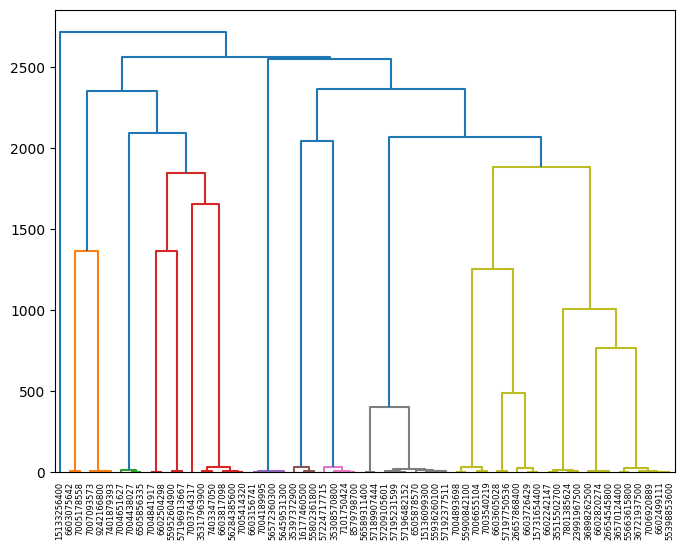

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

Z = hierarchy.linkage(derivative, method)
dn = hierarchy.dendrogram(Z, labels = nodes_list, orientation='top', count_sort='ascending', ax=ax)

plt.show()

## General (us)

In [12]:
h_cut, num_fusion = height_based_cut(Z)

In [13]:
cuttree = hierarchy.cut_tree(Z, height = h_cut)
Communities_dict = {}
for cont, i in enumerate(nodes_list):
    Communities_dict[i] = cuttree[cont][0]

In [14]:
Num_communities = len(set(Communities_dict.values()))
print(Num_communities)

19


In [15]:
communities_dict = communities(H, derivative, method, n_clusters=Num_communities)

nodeset_list = []
nodeset_list_names = []
for nodeset in communities_dict.values():
    nodeset_list.append(nodeset)
    nodeset_list_names.append([IDs_dict[ID] for ID in nodeset])
    print([IDs_dict[ID] for ID in nodeset])

    print("###")

['Zhang X.', 'Barzel B.', 'Havlin S.']
###
['Bragard J.', 'Mendoza C.']
###
['Meucci R.', 'Kurths J.', 'Allaria E.', 'Zhou C.S.', 'Arecchi F.T.']
###
['Mancini H.', 'Maza D.']
###
['Residori S.', 'Ramazza P.L.', 'Bortolozzo U.']
###
['Guo H.', 'Dai X.', 'Jia D.', 'Jusup M.', 'Perc M.', 'Wang Z.', 'Li X.']
###
['Papo D.', 'Sousa P.A.C.', 'Menasalvas E.', 'Zanin M.']
###
['Hramov A.E.', 'Maksimenko V.A.', 'Koronovskii A.A.', 'Makarov V.V.']
###
['Alfaro-Bittner K.', 'Raigorodskii A.M.']
###
['Frasca M.', 'Latora V.', 'Gómez-Gardeñes J.', 'Moreno Y.']
###
['Romance M.', 'Criado R.', 'del Genio C.I.']
###
['Shen C.', 'Shi L.']
###
['Guan S.', 'Liu Z.', 'Qiu T.', 'Zou Y.']
###
['Buldú J.', 'Gutiérrez R.', 'Sevilla-Escoboza R.']
###
['Hwang D.-U.', 'Amann A.', 'Chavez M.']
###
['Soregaroli C.']
###
['Navas A.', 'Almendral J.A.', 'Leyva I.', 'Sendiña-Nadal I.', 'Bajo R.', 'del-Pozo F.']
###
['Valladares D.L.', 'Pecora L.M.']
###
['Giaquinta A.']
###


## Modularity (us)

In [16]:
A, G, mapping = reduced_adjacency_matrix(H)

In [17]:
def calculate_modularities(H, G, Z, verbose=True):
    
    Modularity = []
    for n in range(len(H.nodes)):

        if n % 50 == 0 and verbose:
            print(f'-- {n/len(H.nodes)}% --')

        cuttree = hierarchy.cut_tree(Z, n_clusters = n)
        Communities_dict = {}

        for cont, i in enumerate(H.nodes):
            Communities_dict[i] = cuttree[cont][0]

        # Get the list of communities
        grouped_dict = defaultdict(list)
        for key, val in Communities_dict.items():
            grouped_dict[val].append(key)

        Communities_list = list(grouped_dict.values())

        q = nx.community.modularity(G, Communities_list)

        Modularity.append(q)
        
    return Modularity

In [18]:
Modularity = calculate_modularities(H, G, Z)

-- 0.0% --
-- 0.819672131147541% --


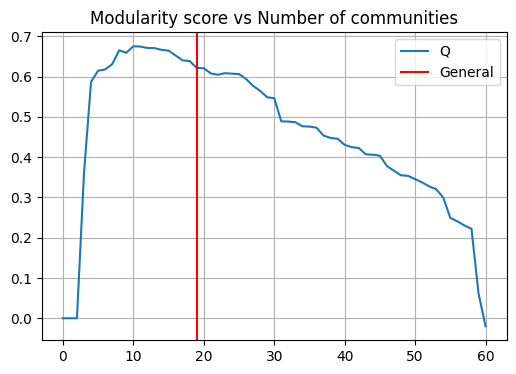

In [19]:
plt.figure(figsize=(6,4))
plt.title("Modularity score vs Number of communities")
plt.plot(range(len(H.nodes)), Modularity, label='Q')
plt.grid()
plt.axvline(Num_communities, color='r', label='General')

plt.legend()

*Conclusion*: the general method coincides with our modularity maximization in this example

In [20]:
m = max(Modularity)
num_fusion = [i for i, j in enumerate(Modularity) if j == m]
index_max = num_fusion[0]

print(f'Number of communities maximizing the modularity is: {index_max},')
print(f'with modularity: {m}')

Number of communities maximizing the modularity is: 10,
with modularity: 0.6753865356138905


In [21]:
communities_dict = communities(H, derivative, method, n_clusters=index_max)

nodeset_list = []
nodeset_list_names = []
for nodeset in communities_dict.values():
    nodeset_list.append(nodeset)
    nodeset_list_names.append([IDs_dict[ID] for ID in nodeset])
    print([IDs_dict[ID] for ID in nodeset])

    print("###")

['Zhang X.', 'Barzel B.', 'Havlin S.']
###
['Meucci R.', 'Maza D.', 'Kurths J.', 'Mendoza C.', 'Allaria E.', 'Zhou C.S.', 'Mancini H.', 'Bragard J.', 'Arecchi F.T.', 'Giaquinta A.']
###
['Residori S.', 'Ramazza P.L.', 'Bortolozzo U.']
###
['Guo H.', 'Dai X.', 'Jia D.', 'Jusup M.', 'Perc M.', 'Shen C.', 'Wang Z.', 'Shi L.', 'Li X.']
###
['Buldú J.', 'Navas A.', 'Almendral J.A.', 'Leyva I.', 'Papo D.', 'Gutiérrez R.', 'Menasalvas E.', 'Sendiña-Nadal I.', 'Sevilla-Escoboza R.', 'Zanin M.', 'Bajo R.', 'Sousa P.A.C.', 'del-Pozo F.']
###
['Hramov A.E.', 'Maksimenko V.A.', 'Koronovskii A.A.', 'Makarov V.V.']
###
['Latora V.', 'Raigorodskii A.M.', 'Alfaro-Bittner K.', 'Criado R.', 'Gómez-Gardeñes J.', 'Frasca M.', 'Romance M.', 'del Genio C.I.', 'Moreno Y.']
###
['Guan S.', 'Liu Z.', 'Qiu T.', 'Zou Y.']
###
['Valladares D.L.', 'Hwang D.-U.', 'Pecora L.M.', 'Chavez M.', 'Amann A.']
###
['Soregaroli C.']
###


### Iterate again over the communities

In [52]:
iterated_partition = []
for comm in nodeset_list:
    
    if len(comm) == 1:
        iterated_partition.append(list(comm))
        print([IDs_dict[list(comm)[0]]])
        
        continue
    
    # Obtain the subhypergraph of the community
    subH = xgi.subhypergraph(H, nodes = comm)
    
    # Compute the derivatives and dendrogram
    sub_derivative = derivative_list(subH)
    subZ = hierarchy.linkage(sub_derivative, method)
        
    # Compute the reduced graph and adjacency matrix
    subA, subG, sub_mapping = reduced_adjacency_matrix(subH)
    
    # Calculate the modularity, and its max
    sub_Modularity = calculate_modularities(subH, subG, subZ, verbose=False)
    
    m = max(sub_Modularity)
    num_fusion = [i for i, j in enumerate(sub_Modularity) if j == m]
    index_max = num_fusion
    
    # Obtain the partition of the subhypergraph
    communities_dict = communities(subH, sub_derivative, method, n_clusters=index_max)
    
    # Print it
    for nodeset in communities_dict.values():
        iterated_partition.append(list(nodeset))
        
        print([IDs_dict[ID] for ID in nodeset])
        print("#######")
        
        
    print("------NEXT------")    
    

['Zhang X.', 'Barzel B.', 'Havlin S.']
#######
------NEXT------
['Bragard J.', 'Mendoza C.']
#######
['Zhou C.S.', 'Kurths J.']
#######
['Mancini H.', 'Maza D.']
#######
['Arecchi F.T.', 'Meucci R.', 'Allaria E.']
#######
['Giaquinta A.']
#######
------NEXT------
['Residori S.', 'Ramazza P.L.', 'Bortolozzo U.']
#######
------NEXT------
['Dai X.', 'Jusup M.', 'Perc M.', 'Wang Z.', 'Li X.']
#######
['Guo H.', 'Shen C.', 'Shi L.', 'Jia D.']
#######
------NEXT------
['Papo D.', 'Sousa P.A.C.', 'Menasalvas E.', 'Zanin M.']
#######
['Buldú J.', 'Gutiérrez R.', 'Sevilla-Escoboza R.']
#######
['Leyva I.', 'Sendiña-Nadal I.', 'Navas A.', 'Almendral J.A.']
#######
['Bajo R.', 'del-Pozo F.']
#######
------NEXT------
['Hramov A.E.', 'Koronovskii A.A.']
#######
['Maksimenko V.A.', 'Makarov V.V.']
#######
------NEXT------
['Raigorodskii A.M.']
#######
['Frasca M.', 'Latora V.', 'Gómez-Gardeñes J.', 'Moreno Y.']
#######
['Alfaro-Bittner K.', 'Romance M.', 'Criado R.', 'del Genio C.I.']
#######
------

In [53]:
q = nx.community.modularity(G, iterated_partition)

In [55]:
print(q)

0.5649781616999181


## Modularity (Kumar)

In [56]:
clusters = IRMM_algorithm(H, tol=1e-3)
Communities_K = []
for comm in clusters:
    Community_K = []
    Community_IDs = []
    for node in comm:
        Community_K.append(mapping[node])
        Community_IDs.append(IDs_dict[mapping[node]])
    Communities_K.append(Community_K)
    
    print(Community_IDs)

q = nx.community.modularity(G,Communities_K)
print(f'The modularity for this partition is: {q}')

It converge after 50 iterations
['Ramazza P.L.', 'Bortolozzo U.', 'Residori S.']
['Koronovskii A.A.', 'Makarov V.V.', 'Maksimenko V.A.', 'Hramov A.E.']
['Jusup M.', 'Li X.', 'Guo H.', 'Raigorodskii A.M.', 'Jia D.', 'Wang Z.', 'Alfaro-Bittner K.', 'Perc M.', 'Shi L.', 'Shen C.', 'Dai X.']
['Amann A.', 'Frasca M.', 'del Genio C.I.', 'Moreno Y.', 'Chavez M.', 'Pecora L.M.', 'Gómez-Gardeñes J.', 'Latora V.', 'Hwang D.-U.']
['Criado R.', 'Romance M.']
['Zou Y.', 'Havlin S.', 'Kurths J.', 'Liu Z.', 'Barzel B.', 'Qiu T.', 'Valladares D.L.', 'Zhang X.', 'Zhou C.S.', 'Guan S.']
['Bragard J.', 'Meucci R.', 'Mancini H.', 'Allaria E.', 'Mendoza C.', 'Arecchi F.T.', 'Giaquinta A.', 'Maza D.']
['Soregaroli C.']
['Buldú J.', 'Menasalvas E.', 'Papo D.', 'Sendiña-Nadal I.', 'Sevilla-Escoboza R.', 'Leyva I.', 'Bajo R.', 'del-Pozo F.', 'Gutiérrez R.', 'Zanin M.', 'Almendral J.A.', 'Navas A.', 'Sousa P.A.C.']
The modularity for this partition is: 0.7120766603598667
